In [2]:
import numpy as np
import random

import h5py
import astropy.io.fits as fits
from astropy.table import Table
from time import gmtime, strftime
import pandas as pd


import sys
sys.path.append('../')
from file_path import *

import os
import re
import matplotlib.pyplot as plt
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 10
from astroML.datasets.tools import SDSSfits
#%matplotlib inline

from tqdm import tqdm


# Define functions

In [3]:
## get data, including adding noise

def _getData(filename, lower=3600, upper=10325, powerlaw=False, redshifted=False, normalize=True, addNoise=False,
             ignorebad=False, goodthreshold = 2600):
    obj=fits.open(filename)    
    data = Table.read(obj, hdu=1)
    if ignorebad:
        data = data[(data['or_mask']==0) & (data['and_mask']==0)] # filter probmatic pixles
        if (len(data) < goodthreshold):
            print('Good length of wavelength:',len(data),', smaller than the limit of',goodthreshold,'.')
            return

    if redshifted:
        z = Table.read(obj,hdu=2)['Z'].item()
        zErr = Table.read(obj,hdu=2)['Z_ERR'].item()
        data['lam'] = data['lam']/(1+z)      
    
    # interplate all wavelength
    loglam = np.linspace(3.5522,4.0139,4618) ## eBOSS range
    lam = 10**loglam
    try:
        flux = np.interp(loglam, data['LOGLAM'], data['FLUX'])
    except:
        flux = np.interp(loglam, data['loglam'], data['flux'])
        
    obj.close()
    
    if powerlaw:
        amp = np.mean(flux[0:200])
        alphas = np.random.uniform(-2,1,5)
        powerlaws = np.asarray([amp*np.random.uniform(0.5,1,1)*(lam/lam[0])**i for i in alphas])
        powerlaw_avg = np.sum(powerlaws,axis=0)/ len(alphas)
        flux = flux + powerlaw_avg

    ## add noise 
    if addNoise:
        factor = np.random.uniform(low=0.2, high=1.0) # scale factor of std
        noise = np.random.normal(0, flux.std()*factor, len(flux))
        flux = flux+noise
    if not addNoise:
        factor = 0
    # trim data
        lam_flux = pd.DataFrame({'loglam': loglam,'lam': lam, 'flux': flux})
        lam_flux = lam_flux[(lam_flux['lam']>lower) & (lam_flux['lam']<upper)]
        loglam = np.asarray(lam_flux['loglam'].to_list())
        lam = np.asarray(lam_flux['lam'].to_list())
        flux = np.asarray(lam_flux['flux'].to_list())
    # normalize data
    if normalize:
        std = np.std(flux)
        avg = np.mean(flux)
        eps = 0.001
        fluxNormalized = (flux - avg)/std
        fluxNormalized -= np.min(fluxNormalized)
        fluxNormalized += eps
        fluxNormalized /= np.max(fluxNormalized)
        dataSelected = pd.DataFrame({'loglam': loglam, 'lam': lam, 'flux': flux, 'fluxNormalized': fluxNormalized})
    if not normalize:
        dataSelected = pd.DataFrame({'loglam': loglam, 'lam': lam, 'flux': flux})   
              
    return dataSelected

def add_noise(flux):
    # normalize data
    std = np.std(flux)
    avg = np.mean(flux)
    eps = 0.001
    fluxNormalized = (flux - avg)/std
    fluxNormalized -= np.min(fluxNormalized)
    fluxNormalized += eps
    fluxNormalized /= np.max(fluxNormalized)
    dataSelected = pd.DataFrame({'fluxNoise': flux, 'fluxNoiseNormalized': fluxNormalized})
    _writefile(filename,dataSelected,z,lower, upper)
    return 


def _writefile(filename,data,z,lower, upper, factor=0):
    name = os.path.splitext(filename)[0]
    if (factor !=0):
        factor =str(np.round(factor,3))
        outputName = name+'-Noise'+factor+'-'+str(int(lower))+'-'+str(int(upper))+'_raw.csv'
    else:
        outputName = name+'-'+str(int(lower))+'-'+str(int(upper))+'_raw.csv'
    f = open(outputName,'w')
    f.write('# Original file: '+str(filename)+'\n')
    f.write('# wavelength range from: '+str(lower)+' to '+str(upper)+'\n')
    f.write('# redshift: '+str(z) +'\n')
    data.to_csv(f)
    f.close()


In [4]:
def exporter(table, in_folder, out_file, isZ_VI=False, isZ_PCA=False):
    file = feature_path+'/'+out_file
    if os.path.exists(file):
        print('File existed:', file)
        return
    if isZ_VI:
        table = table[table['Z_VI']>0]
    if isZ_PCA:
        table = table[table['Z_PCA']>0]
    
    # properties 
    indexs = []
    sdss_names = []
    thing_ids = []
    plates = []
    mjds = []
    fiberids = []
    
    class_persons = []
    is_qso_qns = []
    is_qso_dr12qs = []
    is_qso_finals = []
    autoclass_pqns = []
    autoclass_dr14qs = []
    sn_median_alls = []
    bal_probs = []
    
    z_vis = []
    z_confs = []
    z_dr12qs = []
    zs = []
    z_pipes = []
    z_pcas = []
    z_qns = []
    zwarn_pcas = []
    deltachi2_pcas = []
    
    urls = []
    
    wavelengths = []
    wavelengths_log = []
    fluxs = []
    flux_norms = []

    for row in tqdm(table):
        plate = str(int(row['PLATE']))
        mjd = str(int(row['MJD'])).zfill(5)
        fiberid = str(int(row['FIBERID'])).zfill(4)
        filename = 'spec-'+plate+'-'+mjd+'-'+fiberid+'.fits'
        
        if os.path.exists(in_folder+'/'+filename):  
            try:
                data = _getData(in_folder+'/'+filename, lower=0, upper=20000, normalize=True)
                
                indexs.append(row.index) 
                sdss_names.append(str(row['SDSS_NAME']))
                thing_ids.append(row['THING_ID'])
                plates.append(plate)
                mjds.append(mjd)
                fiberids.append(fiberid)
                
                class_persons.append(row['CLASS_PERSON'])
                is_qso_qns.append(row['IS_QSO_QN'])
                is_qso_dr12qs.append(row['IS_QSO_DR12Q'])
                is_qso_finals.append(row['IS_QSO_FINAL'])
                autoclass_pqns.append(row['AUTOCLASS_PQN'])
                autoclass_dr14qs.append(row['AUTOCLASS_DR14Q'])
                sn_median_alls.append(row['SN_MEDIAN_ALL'])
                bal_probs.append(row['BAL_PROB'])
                
                z_vis.append(row['Z_VI'])
                z_confs.append(row['Z_CONF'])
                z_dr12qs.append(row['Z_DR12Q'])
                zs.append(row['Z'])
                z_pipes.append(row['Z_PIPE'])
                z_pcas.append(row['Z_PCA'])
                z_qns.append(row['Z_QN'])
                zwarn_pcas.append(row['ZWARN_PCA'])
                deltachi2_pcas.append(row['DELTACHI2_PCA'])
                
                rootURL = 'https://data.sdss.org/sas/dr16/eboss/spectro/redux/v5_13_0/spectra/full/'+plate+'/'
                url = rootURL+filename
                urls.append(url)
                
                fluxs.append(data['flux'].tolist())
                flux_norms.append(data['fluxNormalized'].tolist())
                
            except:
                print('Error', filename)          
    
    wavelengths = data['lam'].tolist()
    wavelengths_log = data['loglam'].tolist()
    
    # write to file
    f = h5py.File(file,'w')
    
    dset_sdss_name = f.create_dataset(name="sdss_name", data = sdss_names, dtype=h5py.string_dtype())
    dset_thing_id = f.create_dataset(name="thing_id", data = thing_ids, dtype='i8')
    dset_index = f.create_dataset(name="index", data = indexs, dtype='i8')
    dset_plate = f.create_dataset(name="plate", data = plates, dtype='i8')
    dset_mjd = f.create_dataset(name="mjd", data = mjds, dtype='i8')
    dset_fiberid = f.create_dataset(name="fiberid", data = fiberids, dtype='i8')
    
    dset_class_person = f.create_dataset(name="class_person", data = class_persons, dtype='i8')
    dset_is_qso_dr12q = f.create_dataset(name="is_qso_dr12q", data = is_qso_dr12qs, dtype='i8')
    dset_is_qso_final = f.create_dataset(name="is_qso_final", data = is_qso_finals, dtype='i8')
    dset_is_qso_qn = f.create_dataset(name="is_qso_qn", data = is_qso_qns, dtype='i8')
    dset_autoclass_pqn = f.create_dataset(name="autoclass_pqn", data = autoclass_pqns, dtype=h5py.string_dtype())
    dset_autoclass_dr14q = f.create_dataset(name="autoclass_dr14q", data = autoclass_dr14qs, dtype=h5py.string_dtype())
    dset_sn_median_all = f.create_dataset(name="sn_median_all", data = sn_median_alls, dtype=np.float32)
    dset_bal_prob = f.create_dataset(name="bal_prob", data = bal_probs, dtype=np.float32)
    
    dset_z_vi = f.create_dataset(name="z_vi", data = z_vis, dtype=np.float32)
    dset_z_conf = f.create_dataset(name="z_conf", data = z_confs, dtype=np.float32)
    dset_z_dr12q = f.create_dataset(name="z_dr12q", data = z_dr12qs, dtype=np.float32)
    dset_z = f.create_dataset(name="z", data = zs, dtype=np.float32)
    dset_z_pipe = f.create_dataset(name="z_pipe", data = z_pipes, dtype=np.float32)
    dset_z_pca = f.create_dataset(name="z_pca", data = z_pcas, dtype=np.float32)
    dset_z_qn = f.create_dataset(name="z_qn", data = z_qns, dtype=np.float32)
    dset_zwarn_pca = f.create_dataset(name="zwarn_pca", data = zwarn_pcas, dtype='i8')
    dset_deltachi2_pca = f.create_dataset(name="deltachi2_pca", data = deltachi2_pcas, dtype=np.float32)
    
    dset_url = f.create_dataset(name="url", data = urls, dtype=h5py.string_dtype())

    dset_wavelength = f.create_dataset(name="wavelength", data = wavelengths, dtype=np.float32)
    dset_wavelength_log = f.create_dataset(name="wavelength_log", data = wavelengths_log, dtype=np.float32)
    dset_flux = f.create_dataset(name="flux", data = fluxs, dtype=np.float32)
    dset_flux_norm = f.create_dataset(name="flux_norm", data = flux_norms, dtype=np.float32)
    
    f.attrs['CLASS'] = '0: Not Inspected / 1: Star / 3: Quasar / 30: BAL Quasar / 4: Galaxy / 50: Blazar'
    f.attrs['TIMECREA'] = '2020-07-30 11:54:19'
    f.attrs['TIMEMODI'] = strftime("%Y-%m-%d %H:%M:%S", gmtime())
    f.attrs['REFERENCE'] = 'https://data.sdss.org/datamodel/files/BOSS_QSO/DR16Q/DR16Q_v4.html'
    f.attrs['COMMENTS'] = 'SDSS Spectrum'
    f.attrs['CREATOR'] = 'yu.wang@inaf.it'
    f.attrs['MODIFIER'] = 'yu.wang@inaf.it'
    
    dset_wavelength.attrs['unit'] = 'A'
    dset_flux.attrs['unit'] = '1e-17 erg/cm2/s/A'
    
    f.close()
    
    print('Saved:', file)

In [5]:
# test

Text(0, 0.5, '$\\Delta$ Flux ($10^{-17}erg$ $cm^{-2}$$s^{-1}$$\\mathring{A}^{-1}$)')

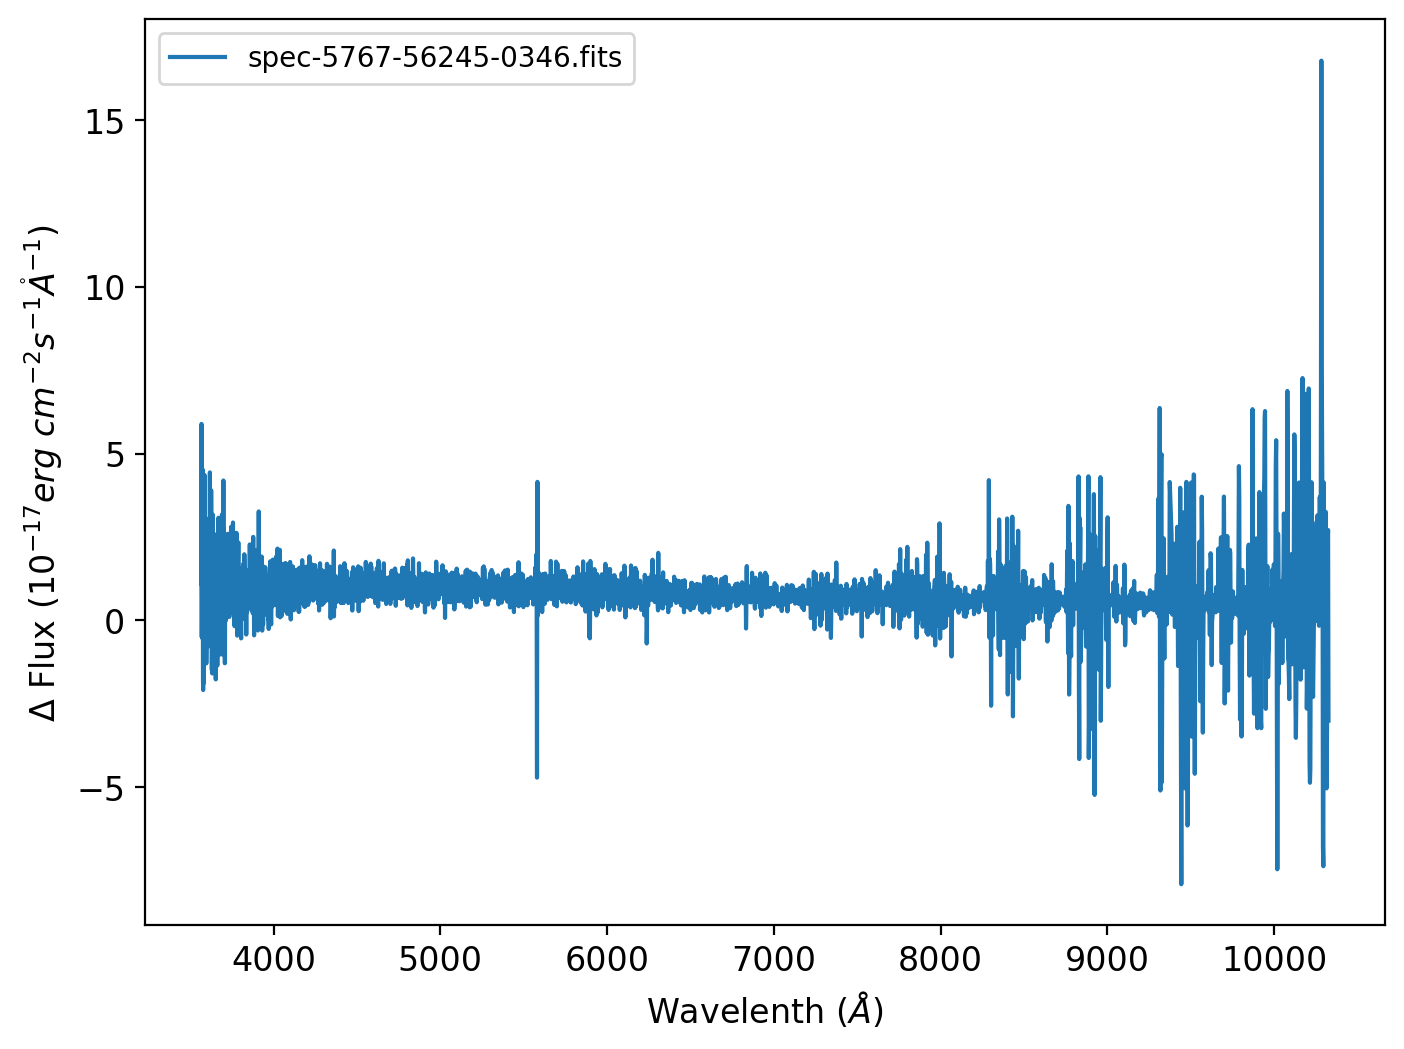

In [6]:
folder = '../../SDSS/DR16Q/'
filenames = [x for x in os.listdir(folder) if x.endswith(".fits")]
data = _getData(folder+filenames[600], lower=0, upper=20000, normalize=True)
plt.plot(data['lam'],data['flux'],label=filenames[600])
#plt.plot(data['lam'],data['fluxNormalized'],label='Original')

plt.legend()
plt.xlabel('Wavelenth ($\AA$)')
plt.ylabel('$\Delta$ Flux ($10^{-17}erg$ $cm^{-2}$$s^{-1}$$\mathring{A}^{-1}$)',fontsize=12)
#plt.xlim(3600,10350)

# Produce h5 File

In [7]:
#catalogue = Table.read('../../SDSS/DR16Q_Superset_v3.fits', format='fits')
#names10000 = catalogue[catalogue['PLATE']>10000]
#names9000 = catalogue[(catalogue['PLATE']<=10000) & (catalogue['PLATE']>9000)]
#names8000 = catalogue[(catalogue['PLATE']<=9000) & (catalogue['PLATE']>8000)]
#names7500 = catalogue[(catalogue['PLATE']<=8000) & (catalogue['PLATE']>7500)]
#names7500 = catalogue[(catalogue['PLATE']<=7500) & (catalogue['PLATE']>7000)]
#names6000 = catalogue[(catalogue['PLATE']<=7000) & (catalogue['PLATE']>6000)]
#names5000 = catalogue[(catalogue['PLATE']<=6000) & (catalogue['PLATE']>5000)]
#names4000 = catalogue[(catalogue['PLATE']<=5000) & (catalogue['PLATE']>4000)]
#names3000 = catalogue[(catalogue['PLATE']<=4000) & (catalogue['PLATE']>3523)]

In [8]:
# split table 
catalogue = Table.read('../../SDSS/DR16Q_Superset_v3.fits', format='fits')
names = locals()
for i in range(100):
    names['n' + str(i) ] = catalogue[(catalogue['PLATE']<=3500+(i+1)*100) & (catalogue['PLATE']>3500+100*i)]

In [9]:
# export h5 file of the splitted table
for i in range(100):
    table = names['n' + str(i)]
    if i > 76:
        if len(table)>0:
            in_folder = '../../SDSS/DR16Q/'
            out_file = 'dr16q-spectrum-n'+str(i).zfill(2)+'.h5'
            exporter(table, in_folder, out_file, isZ_VI=False, isZ_PCA=False)

File existed: ../feature//dr16q-spectrum-n77.h5


100%|██████████| 31268/31268 [10:29<00:00, 49.70it/s] 


Saved: ../feature//dr16q-spectrum-n78.h5


100%|██████████| 693/693 [00:19<00:00, 35.65it/s]


Saved: ../feature//dr16q-spectrum-n79.h5


100%|██████████| 3001/3001 [01:28<00:00, 33.87it/s]


Saved: ../feature//dr16q-spectrum-n80.h5


100%|██████████| 7884/7884 [03:49<00:00, 34.31it/s]


Saved: ../feature//dr16q-spectrum-n81.h5


100%|██████████| 1156/1156 [00:26<00:00, 43.56it/s]


Saved: ../feature//dr16q-spectrum-n82.h5


In [ ]:
#table = names7000
#in_folder = '../../SDSS-data/DR16Q_Superset_v3/7000/'
#out_file = 'dr16q-spectrum-3600-10350-n7000-zvi.h5'
#exporter(table, in_folder, out_file, isZ_VI=True, isZ_PCA=False)

In [16]:
(len(names7000[names7000['Z_VI']>0])+len(names7500[names7500['Z_VI']>0]))/(len(names7000)+len(names7500))

0.33624633817188376

In [15]:
len(names['n68'])

0

In [17]:
len(names9000)

53670

In [19]:
len(names10000[names10000['Z_PCA']>0])

165989